# Online Store Transaction Analysis - Practicum100 Final Project

Project's dashboard: https://public.tableau.com/views/ProductRangeDashboard/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

Project's presentation: https://drive.google.com/file/d/1d4IETOWeRVCSfnltoF6xqi87ngoK_vHm/view?usp=sharing


In the following project, an analysis of the transaction history of an online store that sells household goods will be conducted. The research will focus on the product range in this store. The goal of the analysis is to get better understanding of the product range in the store, and this could help optimize various processes within the store: supply, client demands, sales, client service and more.

The main part of the analysis will focus on popularity - most and least popular products in terms of purchases and revenue; seasonality - what products are more popular on different time of the year; seniority - what are the differences in the popularity of products for different segments of user.

The project will consist of the following sections:
1. Loading the data and necessities
2. Preprocessing
    - 2.1. Transform columns and column names to lowercase
    - 2.2. Address missing and duplicated values
    - 3.3. Convert columns to their correct datatypes
3. EDA
    - 3.1. Get a summary of the data - look for anomalies
    - 3.2. Plot histograms of the columns
4. Analysis
    - 4.1 - Popularity - which are the popular products, which products bring most revenue.
    - 4.2 - Seasonality - How it affects the products and what people buy
    - 4.3 - Seniority - What is the average check of different buyer groups, what items do they buy
5. Hypotheses Tests
    - 5.1. Compare the average order value of new customers vs senior customers
    - 5.2. Compare the average order value between summer and winter
6. Conclusions and recommendations

## Loading the Data
We will start by loading the required libraries and loading the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import seaborn as sns

from scipy import stats as st

In [2]:
try:
    df = pd.read_csv('ecommerce_dataset_us.csv', sep='\t')
except:
    df = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep='\t')

In [3]:
## Print an overview of the data

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


## Preprocessing

There are several actions that should be performed on the data:
1. Transform columns and column names to lowercase - for unity and to reach them easily.
2. Convert columns to their correct datatypes.
3. Address missing and duplicated values.

### Transforming to Lowercase
We will transform column names and `description` column to lower case so it will be unified and easier to access.

In [4]:
## Transform columns to lower case

df.columns = df.columns.str.lower()

In [5]:
## Transform `descrption` column to lowercase

df['description'] = df['description'].str.lower()

### Convert Columns' Data Types

At this stage, we can convert `invoicedate` to datetime type.

In [6]:
df['invoicedate'] = pd.to_datetime(df['invoicedate'], format="%m/%d/%Y %H:%M")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
invoiceno      541909 non-null object
stockcode      541909 non-null object
description    540455 non-null object
quantity       541909 non-null int64
invoicedate    541909 non-null datetime64[ns]
unitprice      541909 non-null float64
customerid     406829 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB


### Missing Values

Let's print the sum of missing values in each column, and the share of them out of the total number of rows.

In [7]:
df.isnull().sum()

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     135080
dtype: int64

In [8]:
print("Share of missing values in column 'description': {:.2%}".format(len(df[df['description'].isnull()])/len(df)))

print("Share of missing values in column 'customerid': {:.2%}".format(len(df[df['customerid'].isnull()])/len(df)))

Share of missing values in column 'description': 0.27%
Share of missing values in column 'customerid': 24.93%


There are records in the dataset where the product description or the customer Id are missing. For `description` column, only a small share (0.27%) of the data is missing. However, for almost a quarter of the transactions, customer Id is missing. Let's investigate deeper the missing values.

#### Missing `description` Values

In [9]:
df[df['description'].isnull()].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN
1971,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN
1972,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,NaN


We can see that customer Id is also missing for these values, perhaps that's a pattern - we will check it soon. We also see that unitprice is zero.
However, we do have `invoiceno` and `stockcode`, and we might be able to fill the missing values using this information, at least for some of the data.

Let's see if the missing rows under `description` also have missing values in `customerid`. We will print a list of the `customerid` values where `description` is missing.

In [10]:
## Get a list of the `customerid` values where `description` is null

df[df['description'].isnull()]['customerid'].value_counts()

Series([], Name: customerid, dtype: int64)

Indeed, all rows that are missing in `description`, are also missing in `customerid`. Let's see if we can use `stockcode` to fill this data. We will get a list of all stockcodes with null values. Then, we will see if they appear in other rows, this time with a description.

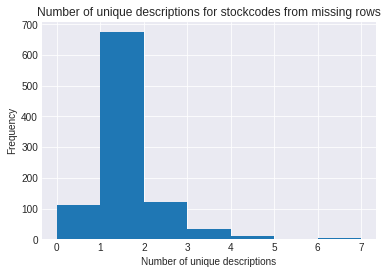

In [11]:
## Get a list of stockcodes with missing values

null_stockcodes = df[df['description'].isnull()]['stockcode'].tolist()

## Get a histogram of unique descriptions per stockcode

df.query('stockcode in @null_stockcodes').groupby('stockcode').agg({'description': 'nunique'}).hist(bins=7)
plt.title('Number of unique descriptions for stockcodes from missing rows')
plt.xlabel('Number of unique descriptions')
plt.ylabel('Frequency');

The vast majority of rows have at least one value we can use to complete our missing values. Only about 100 rows will be left without a description. However, we should check why some products have up to 7 different descriptions.

In [12]:
## Get stockcodes with most unique values

df.query('stockcode in @null_stockcodes').groupby('stockcode').agg({'description': 'nunique'}).sort_values(by='description', ascending=False).head()

,description
stockcode,
23084,7
20713,7
21830,6
85175,6
21181,5


Let's take a closer look at one of them - `stockcode=23084`

In [13]:
df[df['stockcode']=='23084']['description'].value_counts()

rabbit night light                     1051
amazon                                    1
website fixed                             1
add stock to allocate online orders       1
allocate stock for dotcom orders ta       1
for online retail orders                  1
temp adjustment                           1
Name: description, dtype: int64

We can see now that there's a large number of rows that probably contain the right product name (rabbit night light). It seesms that rarely an internal note appears instead of the product name. The good news is that we can use the most common value and fill it instead of our missing products.

We will use the stockcode of rows with missing description value, to find what is the most common description value in other rows. We will use this value to fill in the missing value.

In [14]:
## Saving a list of missing values indexes, so we can check them later

missing_values_index = df[df['description'].isnull()].index

In [15]:
## Create a function that will return the most common description value, if possible

def myFunc(row):
    try:
        return row.value_counts().index[0]
    except:
        pass

## Fill NaN values based on `stockcode` grouping

df['description'] = df['description'].fillna(df.groupby(['stockcode'])['description'].transform(myFunc))


In [16]:
## Let's check that it worked

df.loc[missing_values_index].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
622,536414,22139,retrospot tea set ceramic 11 pc,56,2018-11-29 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN
1971,536546,22145,christmas craft heart stocking,1,2018-11-29 14:33:00,0.0,NaN
1972,536547,37509,new england mug w gift box,1,2018-11-29 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,NaN


In [17]:
df.isnull().sum()

invoiceno           0
stockcode           0
description       112
quantity            0
invoicedate         0
unitprice           0
customerid     135080
dtype: int64

We reduced the number of missing values to only 112. Let's simply fill the rest of the missing values with "unknown".

In [18]:
df['description'] = df['description'].fillna("unknown")

print("Number of missing values in `description` column is {}.".format(df['description'].isnull().sum()))

Number of missing values in `description` column is 0.


**Conclusion**

We managed to fill in most missing values for in this column using the stock code. The rest of the values got an 'unknown' value. We don't have any other missing values for `description`, and we can move on.

#### `unitprice` column

There are no missing values in this column. However, we saw that many rows with missing `description` value had a unit price of zero - let's see if this happened to all products with missing `description`:

In [19]:
## Get an overview of `unitprice` for rows with missing product name

df.loc[missing_values_index]['unitprice'].describe()

count    1454.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: unitprice, dtype: float64

As suspected, all rows where `description` was missing, have zero instead of unitprice. The data for this column was probably derived from the product name, and could not be retrieved since the product name was not known.

Let's see if we can use the same process we used before, and get unitprice using the stockcode. First, we need to know how many unitprice each product has. Let's plot a distribution of the number of different unit prices per product.

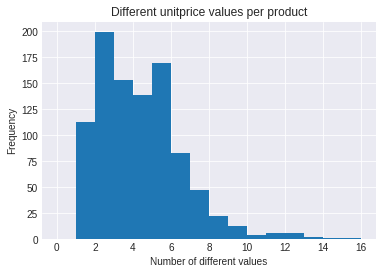

In [20]:
df.query('stockcode in @null_stockcodes').groupby(['stockcode']).agg({'unitprice': 'nunique'}).hist(range=(0,16), bins=16)

plt.title('Different unitprice values per product')
plt.xlabel('Number of different values')
plt.ylabel('Frequency');

There are many products with more than 1 price. Let's look at the products with most different unitprice values.

In [21]:
df.query('stockcode in @null_stockcodes').groupby('stockcode').agg({'unitprice': 'nunique'}).sort_values(by='unitprice', ascending=False).head()

,unitprice
stockcode,
DOT,687
POST,114
79321,16
21175,14
21033,13


Some products have more than 100 different values - but they are not regular products - they probably indicate postage costs. Let's get a closer look at one of the products at the top of the list, `stockcode=79321`.

In [22]:
df[df['stockcode']=='79321']['unitprice'].value_counts()

5.75     297
4.95     175
12.46    103
4.25      50
10.17     17
10.79     13
0.00       7
9.96       6
17.88      3
11.02      3
3.82       3
4.65       2
4.70       1
14.95      1
3.98       1
5.79       1
Name: unitprice, dtype: int64

Some products have more than 100 different unit prices - but they are exceptions. However, there are still many products that have up to 16 different prices. Choosing the most common price will not necessarily be accurate, as prices change over time. If we take into account the *date*, we can get more reliable results.

We currently have indication of the date and time to the exact minute of the transaction. We need to create a column with a wider time frame. A week seems like a reasonable time frame - we don't expect many changes in price during a week.

In [23]:
## Create column `week` that will indicate the week of the transaction

df['week'] = df['invoicedate'].astype('datetime64[W]')

Let's see the distribution of unitprices after we group products by week.

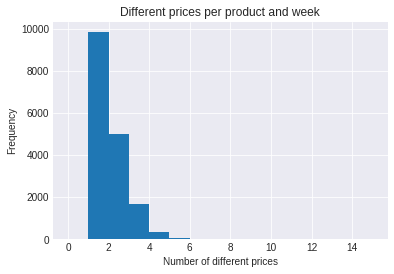

In [24]:
df.query('stockcode in @null_stockcodes').groupby(['stockcode', 'week']).agg({'unitprice': 'nunique'}).hist(range=(0,15), bins=15);

plt.title('Different prices per product and week')
plt.xlabel('Number of different prices')
plt.ylabel('Frequency');

The situation looks better now. Most products now have only 1 price, about half this number has 2 prices and a much smaller amount have more than that. For such cases, we will use the median. We can now finally update `unitprice` in the products.

In [25]:
## We temporarily drop the values in `unitprice` column where `description` was missing

df.loc[missing_values_index] = df.loc[missing_values_index].drop('unitprice', axis=1)

## And then fill the missing values with the mean unitprice based on the stockcode

df['unitprice'] = df['unitprice'].fillna(df.groupby(['stockcode','week'])['unitprice'].transform('median'))

Let's check how many missing values are left in `unitprice` now.

In [26]:
print("Number of missing values in `unitprice` after filling: {}".format(df.loc[missing_values_index]['unitprice'].isnull().sum()))

Number of missing values in `unitprice` after filling: 721


We managed to fill the price for half of the values which did not have unitprice. We're left with 721 values for which we couldn't calculate an accurate number. It's better to fill them back to zero, than to try and fill them with other, less accurate values.

In [27]:
## Fill `unitprice` missing values with zero

df['unitprice'] = df['unitprice'].fillna(0)

**Conclusion**

We managed to fill half of the values which had zero value for their unitprice, with the unitprice of the product in the respective week. The values we could not fill, were changed back to zero. We can now continue.

#### Missing `customerid` Values

Let's see if we can fill customer Id in the same manner we did before. We might be able to use `invoiceno` to find customer Id in rows it is not available. 

Let's first get the invoice numbers of rows where `customerid` is null. Then, we will see how many unique values these invoices have for customer Id. If customer Id was logged in a different row for this invoice, we will be able to use it.

In [28]:
## Get a list of invoices for missing customer Id

null_invoiceno = df[df['customerid'].isnull()]['invoiceno'].tolist()

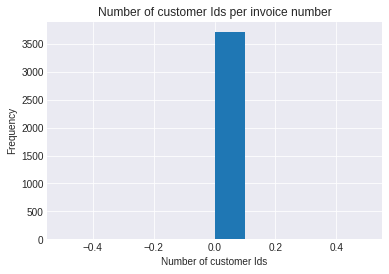

In [29]:
## Draw a histogram

df.query('invoiceno in @null_invoiceno').groupby(['invoiceno']).agg({'customerid': 'nunique'}).hist()

plt.title("Number of customer Ids per invoice number")
plt.xlabel("Number of customer Ids")
plt.ylabel("Frequency");

In [30]:
## Get value counts

df.query('invoiceno in @null_invoiceno').groupby(['invoiceno']).agg({'customerid': 'nunique'})['customerid'].value_counts()

0    3710
Name: customerid, dtype: int64

Unfortunately, there are no records of customer Id for these invoices - in all of them, customer Id is missing. We will fill the missing values with 'uknown', this way we will be able to analyze them separately.

In [31]:
## Fill missing values with 'unknown'

df['customerid'] = df['customerid'].fillna('unknown')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
invoiceno      541909 non-null object
stockcode      541909 non-null object
description    541909 non-null object
quantity       541909 non-null int64
invoicedate    541909 non-null datetime64[ns]
unitprice      541909 non-null float64
customerid     541909 non-null object
week           541909 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 33.1+ MB


**Conclusion**

We could not fill the missing values in `customerid` using other columns. We had to fill them with 'unknown'. We can now move on with the analysis.

### Duplicated Values

Let's print the total number of duplicated values.

In [33]:
df.duplicated().sum()

5268

There are a few thousands of duplicated values. Let's examine them a little bit deeper.

In [34]:
## Print the duplicates

df[df.duplicated()]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,week
517,536409,21866,union jack flag luggage tag,1,2018-11-29 11:45:00,1.25,17908,2018-11-29
527,536409,22866,hand warmer scotty dog design,1,2018-11-29 11:45:00,2.10,17908,2018-11-29
537,536409,22900,set 2 tea towels i love london,1,2018-11-29 11:45:00,2.95,17908,2018-11-29
539,536409,22111,scottie dog hot water bottle,1,2018-11-29 11:45:00,4.95,17908,2018-11-29
555,536412,22327,round snack boxes set of 4 skulls,1,2018-11-29 11:49:00,2.95,17920,2018-11-29
...,...,...,...,...,...,...,...,...
541675,581538,22068,black pirate treasure chest,1,2019-12-07 11:34:00,0.39,14446,2019-12-05
541689,581538,23318,box of 6 mini vintage crackers,1,2019-12-07 11:34:00,2.49,14446,2019-12-05
541692,581538,22992,revolver wooden ruler,1,2019-12-07 11:34:00,1.95,14446,2019-12-05
541699,581538,22694,wicker star,1,2019-12-07 11:34:00,2.10,14446,2019-12-05


There are 5268 duplicated values - this means, 5268 rows that have identical rows in the dataset. Each transaction has invoice number and the time of the purchase, to the exact minute. 

This leaves us with two options:
1. The duplicated values are the result of an error.
2. The duplicated values are simply products that were bought twice (or more) at the same purchase. It is possible that instead of registering two products in the same row and updating the quantity accordingly, two identical products were registered separately.

**Conclusion**

Since we cannot determine which of the two options occured, we will leave the duplicated values in place and treat them as legitimate records.

### Preprocessing Conclusions

In this section, we went preprocessed the data and got it ready for analysis. We first transformed the column names and the products in `description` column to lowercase, to make it easier to access and analyze. Then, we converted the column `invoicedate` to datetime data type.

Then, we addressed missing. We had a small number of missing values in `description` and `customerid` columns. We used the stockcodes to fill in most of the product names that were missing in `description` column. The data for about 100 rows could not be retrieved, and they were filled with the value 'unknown'. 

Data in the column `unitprice` was also missing in this rows. Unit price for the missing products could not be derived, so it showed zero value instead. Once again, we used stockcode to retrieve the unit price for the missing products. Since prices tend to vary over time, we also took into consideration the week in which the product was purchased.

Finally, we addressed missing values in `customerid` column, where 25% of the data is missing. We could not retrieve this information in a similar manner to what we did in other columns. Therefore, we filled the missing values with 'unknown' value.

We then looked for duplicated values. The dataset contains around 5,000 duplicated values. Since we cannot determine that they are false records, and there is a chance that they are legitimate, we will consider them as legitimate records.

## Exploratory Data Analysis

In this section, we will explore the data to get better understanding of it. We will explore the general statistics of the columns, plot histograms and look for anomalies.

### `invoiceno`

In [35]:
df['invoiceno'].describe()

count     541909
unique     25900
top       573585
freq        1114
Name: invoiceno, dtype: object

There are 541,909 records of products that were bought in 25,900 unique invoice numbers. This means, that the dataset contains 25,900 different purchases.

In [36]:
print("The average number of products per purchase is {:.2f}.".format(len(df) / df['invoiceno'].nunique()))

The average number of products per purchase is 20.92.


The average purchase size seems quite large - almost 21 different products, on average, per purchase. Let's dig deeper and see the distribution of products per invoice number.

In [37]:
df.groupby('invoiceno').agg({'description': 'count'}).describe()

,description
count,25900.000000
mean,20.923127
std,43.031334
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1114.000000


The median seems more reasonable - 10 products per purchase. The mean is pushed up by extreme values as 1,114 products in one invoice. Let's have a look at the invoices with the greatest number of products.

In [38]:
df.groupby('invoiceno').agg({'description': 'count'}).sort_values(by='description', ascending=False).head()

,description
invoiceno,
573585,1114
581219,749
581492,731
580729,721
558475,705


Let's take a closer look at `invoice 573585`, the largest purchase in out dataset.

In [39]:
df[df['invoiceno']=='573585']

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,week
430237,573585,11001,asstd design racing car pen,2,2019-10-29 14:41:00,3.29,unknown,2019-10-24
430238,573585,15036,assorted colours silk fan,15,2019-10-29 14:41:00,1.63,unknown,2019-10-24
430239,573585,15039,sandalwood fan,15,2019-10-29 14:41:00,1.63,unknown,2019-10-24
430240,573585,15056BL,edwardian parasol black,1,2019-10-29 14:41:00,12.46,unknown,2019-10-24
430241,573585,15056N,edwardian parasol natural,1,2019-10-29 14:41:00,12.46,unknown,2019-10-24
...,...,...,...,...,...,...,...,...
431346,573585,90209C,pink enamel+glass hair comb,3,2019-10-29 14:41:00,2.07,unknown,2019-10-24
431347,573585,90214S,"letter ""s"" bling key ring",1,2019-10-29 14:41:00,0.83,unknown,2019-10-24
431348,573585,DOT,dotcom postage,1,2019-10-29 14:41:00,2019.05,unknown,2019-10-24
431349,573585,gift_0001_20,dotcomgiftshop gift voucher £20.00,1,2019-10-29 14:41:00,16.67,unknown,2019-10-24


We instantly see that alongside products with a quantity of 1, there are others with quantity 15. Let's get a distribution of the quantities in this order.

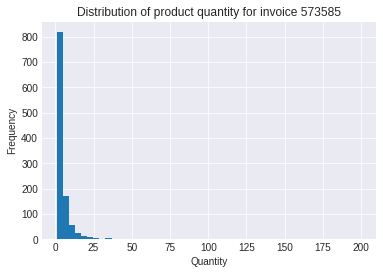

In [40]:
df[df['invoiceno']=='573585']['quantity'].hist(bins=50)

plt.title("Distribution of product quantity for invoice 573585")
plt.xlabel("Quantity")
plt.ylabel("Frequency");

Most products were bought in quantity below 10 items, but we can see quite a few that were bought in 25 and more, all the way up to 200 items of the same product. Let's see which items were bought in the largest quantities.

In [41]:
df[df['invoiceno']=='573585'].query('quantity > 50')

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,week
430437,573585,21802,christmas tree heart decoration,121,2019-10-29 14:41:00,0.42,unknown,2019-10-24
430438,573585,21803,christmas tree star decoration,148,2019-10-29 14:41:00,0.42,unknown,2019-10-24
430450,573585,21824,painted metal star with holly bells,78,2019-10-29 14:41:00,0.83,unknown,2019-10-24
430693,573585,22577,wooden heart christmas scandinavian,95,2019-10-29 14:41:00,0.83,unknown,2019-10-24
430715,573585,22601,christmas retrospot angel wood,105,2019-10-29 14:41:00,1.63,unknown,2019-10-24
430890,573585,22998,travel card wallet keep calm,200,2019-10-29 14:41:00,0.75,unknown,2019-10-24


Seems like it's all about christmas decorations and travel card wallets. Perhaps they were bought in order to be given as a gift? Let's try to calculate the total sum of this purchase. We'll use quantity times unitprice for each product and them sum them all up.

In [42]:

print("The sum of invoice 573585 is {:.2f}".format((df[df['invoiceno']=='573585']['quantity']*df[df['invoiceno']=='573585']['unitprice']).sum()))

The sum of invoice 573585 is 16874.58


This purchase cost almost 17 thousand (probably dollars). The large quantities, the large number of products and the cost of the purchase suggests that it does not belong to a private person - rather to some kind of organization or company. It is likely that other invoices with larger amount of products are the same. 

### `stockcode`

In [43]:
print("There are {} different stockcodes in the dataset, and {} different descriptions.".format(
    df['stockcode'].nunique(),
    df['description'].nunique()))

There are 4070 different stockcodes in the dataset, and 4207 different descriptions.


There are 4070 products that were sold in the store. When comparing to `description` table, we need to remember that we had around 100 products without product name, and we also need to remember that we saw stockcodes that had more than one description, mostly internal notes. 

In [44]:
df['stockcode'].describe()

count     541909
unique      4070
top       85123A
freq        2313
Name: stockcode, dtype: object

The most frequenct stockcode is `85123A` with more than 2300 times it was purchased, but we will go deeper in that subject later. For now, let's see how frequently the products in the dataset are being bought.

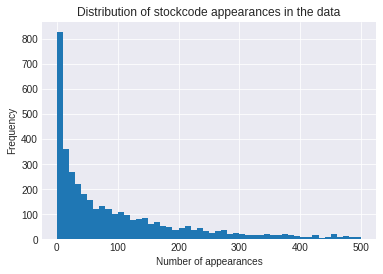

In [45]:
df['stockcode'].value_counts().hist(range=(0,500), bins=50)

plt.title("Distribution of stockcode appearances in the data");
plt.xlabel("Number of appearances")
plt.ylabel("Frequency");

About 20% of the product were bought only a few times. However, we can see that around 100 products were bought 100 times, ~50 were bought 200 times and even at 500 times there are several products.

In general, a large share of the products are being purchased rarely, but the seems like most products were bought at least 10 times during the period of analysis.

### `description`

In [46]:
df['description'].value_counts()

white hanging heart t-light holder    2369
regency cakestand 3 tier              2200
jumbo bag red retrospot               2159
party bunting                         1727
lunch bag red retrospot               1638
                                      ... 
acrylic jewel snowflake,pink             1
found by jackie                          1
dotcom adjust                            1
jardin etched glass butter dish          1
baking mould cupcake chocolate           1
Name: description, Length: 4207, dtype: int64

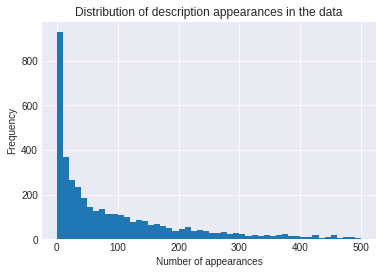

In [47]:
df['description'].value_counts().hist(range=(0,500), bins=50)

plt.title("Distribution of description appearances in the data");
plt.xlabel("Number of appearances")
plt.ylabel("Frequency");

The distribution of `description` is very similar to `stockcode`, and this helps us understand that there is a pretty high degree of correspondence between the values in the two columns. 

We do see, however, that the number of description values with only one appearance is higher by about 100 than the number in `stockcode`. This shows, once again, that there are around 100 description values that are incorrect, and has been used as internal notes.

### `quantity`

In [48]:
df['quantity'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: quantity, dtype: float64

In [49]:
print("Number of quantity > 0 (Sales): {}".format(df.query('quantity > 0')['quantity'].count()))
print("Number of quantity < 0 (Returns): {}".format(df.query('quantity < 0')['quantity'].count()))

Number of quantity > 0 (Sales): 531285
Number of quantity < 0 (Returns): 10624


We can see a very unique min and max values - 80,995 below and above zero. This is probably a mistake and its cancellation. 
We also see that average quantity is 9.5 while the median is only 3. This means that there are large quantities that push the mean up. The vast majority of the data are sales, and around 10,600 rows indicate cancelations\returns.

Let's have a deeper look at the max and min values.

In [50]:
## Get 10 highest\lowest quantities

top_quantities = df['quantity'].sort_values(ascending=False).head(10).to_frame()
low_quantities = df['quantity'].sort_values(ascending=False).tail(10).to_frame()

## Add their description and stockcodes

top_quantities[['description', 'stockcode']] = df.loc[top_quantities.index][['description', 'stockcode']]
low_quantities[['description', 'stockcode']] = df.loc[low_quantities.index][['description', 'stockcode']]

## Print

top_quantities

,quantity,description,stockcode
540421,80995,"paper craft , little birdie",23843
61619,74215,medium ceramic top storage jar,23166
502122,12540,asstd design 3d paper stickers,84826
74614,5568,icon mug revolutionary,37413
421632,4800,world war 2 gliders asstd designs,84077
206121,4300,small popcorn holder,22197
220843,4000,?,85123A
97432,3906,empire design rosette,22053
270885,3186,essential balm 3.5g tin in envelope,18007
160546,3114,fairy cake flannel assorted colour,21108


Except one (`stockcode 85123A`), all products seem to have a description and a stockcode. Yet, the quantity of them is unusually high. Let's check the cancelations - lowest quantity values.

In [51]:
low_quantities

,quantity,description,stockcode
323458,-3167,piece of camo stationery set,16259
341601,-3667,popart wooden pencils asst,16045
431381,-4830,"unsaleable, destroyed.",79323W
115818,-5368,throw away,72140F
225528,-9058,printing smudges/thrown away,23003
4287,-9360,rotating silver angels t-light hldr,84347
225530,-9600,printing smudges/thrown away,23005
225529,-9600,printing smudges/thrown away,23005
61624,-74215,medium ceramic top storage jar,23166
540422,-80995,"paper craft , little birdie",23843


First of all, we see that the two highest quantities were canceled - they were probably recorded by mistake. Other values indicate products that were thrown away because they were unsaleable. We're left with 3 values of what appears to be legitimate cancelations for products. Oddly, we don't see a record of these values being bought - perhaps they were bought before we had a record, or they were grouped together from different purchases. Or maybe, they weren't sold in the store at all, and they indicate some other arrangement. 

We are also still left with quite a few products that were bought in a very large quantity, and there is no indication to cancelation. Perhaps these object were really bought in these quantities: we already encountered a purchase with over 1,000 different products, which concluded belongs to an orgenization or a company. Perhaps the larger quantities were also bought by a larger body.

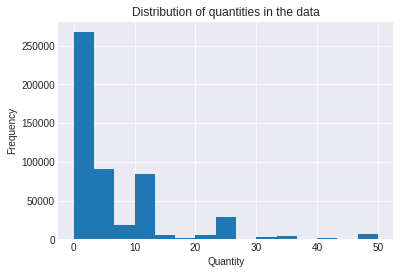

In [52]:
df['quantity'].hist(range=(0,50), bins=15)

plt.title("Distribution of quantities in the data");
plt.xlabel("Quantity")
plt.ylabel("Frequency");

As can be seen, the vast majority of quantities of products is up to 15. More than half of the quantities are smaller than 5. 
This shows that despite several outliers, most transactions did not involve very large quantities.

### `invoicedate`

In [53]:
df['invoicedate'].describe()

count                  541909
unique                  23260
top       2019-10-29 14:41:00
freq                     1114
first     2018-11-29 08:26:00
last      2019-12-07 12:50:00
Name: invoicedate, dtype: object

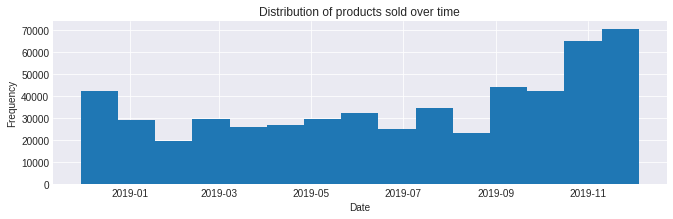

In [54]:
plt.figure(figsize=(11,3))
df['week'].hist(bins=15)
plt.title("Distribution of products sold over time")
plt.xlabel("Date")
plt.ylabel("Frequency");

There are recorded sales of a period slightly over one year, from the 2018-11-29 to 2019-12-07. We can see that the number of products sold at the end of 2018 was relatively high, followed by a decrease when 2019 started. Levels remained about the same until September 2019, when they went up. Then, towards the end of 2019 another jump occured with numbers peaking more than twice their level during the year.

### `unitprice`

In [55]:
df['unitprice'].describe()

count    541909.000000
mean          4.616826
std          96.760935
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: unitprice, dtype: float64

Most of the unit prices are up to 4, but once again we have exterme values. Here as well, there are unit price over zero and below zero. Let's see the numbers.

In [56]:
print("Number of unitprice > 0: {}".format(df.query('unitprice > 0')['unitprice'].count()))
print("Number of unitprice < 0: {}".format(df.query('unitprice < 0')['unitprice'].count()))

Number of unitprice > 0: 540122
Number of unitprice < 0: 2


Only two rows have unitprice < 0. Let's see them.

In [57]:
df.query('unitprice < 0')

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,week
299983,A563186,B,adjust bad debt,1,2019-08-10 14:51:00,-11062.06,unknown,2019-08-08
299984,A563187,B,adjust bad debt,1,2019-08-10 14:52:00,-11062.06,unknown,2019-08-08


As the description says, it is not a record of a product, but a debt that was adjusted.

In [58]:
df.sort_values(by='unitprice', ascending=False).head(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,week
222681,C556445,M,manual,-1,2019-06-08 15:31:00,38970.00,15098,2019-06-06
524602,C580605,AMAZONFEE,amazon fee,-1,2019-12-03 11:36:00,17836.46,unknown,2019-11-28
43702,C540117,AMAZONFEE,amazon fee,-1,2019-01-03 09:55:00,16888.02,unknown,2019-01-03
43703,C540118,AMAZONFEE,amazon fee,-1,2019-01-03 09:57:00,16453.71,unknown,2019-01-03
16356,C537651,AMAZONFEE,amazon fee,-1,2018-12-05 15:49:00,13541.33,unknown,2018-11-29
15017,537632,AMAZONFEE,amazon fee,1,2018-12-05 15:08:00,13541.33,unknown,2018-11-29
15016,C537630,AMAZONFEE,amazon fee,-1,2018-12-05 15:04:00,13541.33,unknown,2018-11-29
16232,C537644,AMAZONFEE,amazon fee,-1,2018-12-05 15:34:00,13474.79,unknown,2018-11-29
524601,C580604,AMAZONFEE,amazon fee,-1,2019-12-03 11:35:00,11586.50,unknown,2019-11-28
299982,A563185,B,adjust bad debt,1,2019-08-10 14:50:00,11062.06,unknown,2019-08-08


The rows with the highest unitprice seem to be technical records, and don't represent a product that was sold.

Let's ignore the outliers and get a histogram that hows majority of the data.

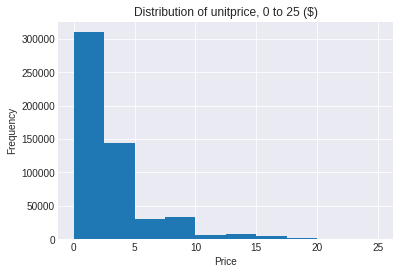

In [59]:
df['unitprice'].hist(range=(0,25));

plt.title("Distribution of unitprice, 0 to 25 ($)")
plt.xlabel("Price")
plt.ylabel("Frequency");

Most unit prices (over 300,000) are up to 2.5, and about half that number are up to 5. Seems like the store sells mostly cheap products. A purchase of a product more expensive than 5 dollars is not frequent.

### `customerid`

In [60]:
df['customerid'].describe()

count      541909
unique       4373
top       unknown
freq       135080
Name: customerid, dtype: object

There are 4373 unique customer Ids in the dataset. As mentioned before, in around 25% of the transactions the customer Id is unknown. 

Let's see how transactions are distributed among the rest of the customers. First, let's see the most 'loyal' customers, and how many products they bought.

In [61]:
df['customerid'].value_counts().head()

unknown    135080
17841.0      7983
14911.0      5903
14096.0      5128
12748.0      4642
Name: customerid, dtype: int64

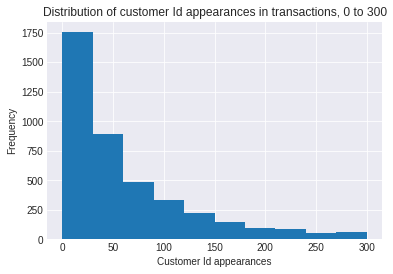

In [62]:
df['customerid'].value_counts().hist(range=(0,300))

plt.title('Distribution of customer Id appearances in transactions, 0 to 300')
plt.xlabel('Customer Id appearances')
plt.ylabel('Frequency');

Some customers have bought thousands of products during the period of the study. However, it's not the case for most users. Most frequently, users bought up to 25 products. A bit less than a quarter of them bought up to 50 products. Then, the number continues to decrease as the number of products rises.

Still, it seems that there many customers have a pretty full cart, and probably come back for more than one visit in the store.

### Conclusions

In the EDA section, we studied each of the columns in the dataframe.

We saw that most invoices have up to 20 different products, but that there are also some invoices with up to 1,000 products. The first probably belongs to private people, while the latter to organizations or companies. 

We then saw that the dataset contains around 4,000 different product `stockcode`s, a large share of them was only bought rarely, but most of them were bought multipe times. `description` table showed similar results, and this means that most products have the right product name associated to their stock code.

In `quantity`, we saw some very high values - above and below zero, where negative value represents a cancellation. We saw that some of the high values were mistakes that were canceled, others were unselable products, and some of them could not be ruled out as legitimate transactions with very high quantities. These are probably purchases made by organizations or companies, not by private people. The vast majority of products, however, were bought in quantities of up to 15 per product.

`invoicedate` shows the analysis period, November 2018 to December 2019. It also shows that the number of products sold was relatively higher towards the end of 2018, then decreased during 2019. Towards the end of 2019, the number rose again to record high numbers in November-December 2019.

In `unitprice`, higher values appear to be the result of internal notes and financial adjustments, as well as negative values. Most products in the store have a unit price of up to 5 dollars.

In 25% of the rows, `customerid` is unknown. The dataset includes ~4400 known customers. The most "loyal" of them accumulated thousands of products they purchased, but they are obviously a few. More frequently, customers by up to 25 products, but there are many of them with more than that. Many customers buy a relatively great number of products, probably in more than one purchase, as there are hundreds of customers who bought 100 products and more.

## Analysis

In this chapter, the main analysis will be performed. We will address the following subjects:
1. Popularity - 
    - Which products are most popular?
    - Which products bring most revenue?
2. Seasonality - 
     - How it affects the most popular products?
     - What are the most popular products in each season?
     - Is the average order size affected by seasonality? Are people buying more in a particular season?
3. Seniority - One-time vs Returning customers 
    - What is the average check of each group? Are one-time customers tend to seize the occasion, and buy more?
    - What are the most popular products in each group?

### Popularity
In this section, we will investigate the following questions:
1. Which products are most popular?
2. Which products bring most revenue?

#### Most Popular Products

We will determine the most popular products by three methods:
1. Number of appearances in the dataset.
2. Number of appearances in unique invoices (and their share of total invoices).
3. Number of purchases by unique customer Ids (and their share of total customers).

This way, we will be able to overcome the fact that some columns have information that might not be reliable for this purposes (for example, `quantity`). In addition to that, we will get an idea of what products are most widely popular among buyers.


##### Number of appearances

Our first method will simply check what products appear the most in the dataset. Each row in the dataset means that this product was part of a purchase.

In [63]:
## Get a list of products with their number of appearances 

appearance_popularity = df['description'].value_counts().to_frame().reset_index()
appearance_popularity.columns = ['description', 'count']

## Print top 5

appearance_popularity.sort_values(by='count', ascending=False).head()

,description,count
0,white hanging heart t-light holder,2369
1,regency cakestand 3 tier,2200
2,jumbo bag red retrospot,2159
3,party bunting,1727
4,lunch bag red retrospot,1638


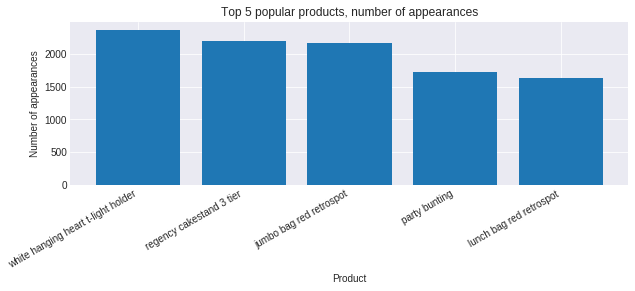

In [64]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(appearance_popularity.sort_values(by='count', ascending=False).head()['description'],
       appearance_popularity.sort_values(by='count', ascending=False).head()['count'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products, number of appearances")
plt.ylabel("Number of appearances");

We got our first 5 candidates. Let's move on and compare them to the next rate.

The following table we are about to create will serve us for both rates. For each product, we will find the number of unique invoices and customer Ids that come with it. Then, we will calculate the share of these numbers of the total number of invoices and customers.

In [65]:
## For each product, count the number of unique invoices and customer Ids

unique_popularity = df.groupby('description').agg({'invoiceno': 'nunique', 'customerid': 'nunique'}).reset_index().sort_values(by='invoiceno', ascending=False)

## Calculate the share from total invoices\customer numbers

unique_popularity['invoice_pct'] = unique_popularity['invoiceno']/df['invoiceno'].nunique()*100
unique_popularity['customerid_pct'] = unique_popularity['customerid']/df['customerid'].nunique()*100

##### Share of total invoices

The next index will select the products that appeared in largest number of different invoices. This will help us find products that are most often being purchased. This list is less affected by cases a product was bought multiple times in a single purchase.

In [66]:
## Print top 5

unique_popularity[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()

,description,invoiceno,invoice_pct
4009,white hanging heart t-light holder,2302,8.888031
2967,regency cakestand 3 tier,2169,8.374517
1901,jumbo bag red retrospot,2135,8.243243
2520,party bunting,1706,6.586873
2093,lunch bag red retrospot,1607,6.204633


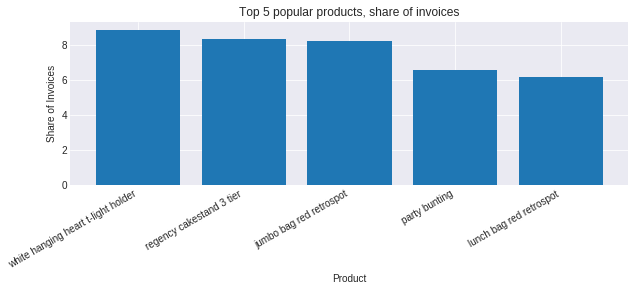

In [67]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['description'],
       unique_popularity[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['invoice_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products, share of invoices")
plt.ylabel("Share of Invoices");

Same top 5 products appear in this list as well. These products appear in 6-9% of the purchases in the store.

##### Share of total customers

In [68]:
## Print top 5

unique_popularity[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()

,description,customerid,customerid_pct
2967,regency cakestand 3 tier,888,20.306426
4009,white hanging heart t-light holder,859,19.643265
2520,party bunting,709,16.213126
254,assorted colour bird ornament,680,15.549966
3254,set of 3 cake tins pantry design,641,14.658129


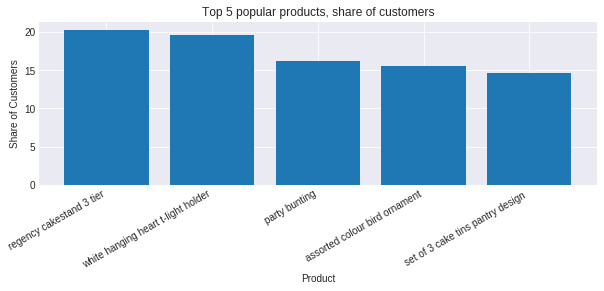

In [69]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['description'],
       unique_popularity[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['customerid_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products, share of customers")
plt.ylabel("Share of Customers");

The top 3 products remain, but changed their order, and they were bought by 16 to 20% of the customers. The products 'jumbo bag red retrospot' and 'lunch bag red retrospot' were replaced two different products. 

##### Conclusions

The most popular products by all three rates are:
- white hanging heart t-light holder
- regency cakestand 3 tier
- party bunting

These projects were bought more than any other products, and on the widest variety of occurences. In addition, they enjoy the widest popularity among different customers, with 16 to 20% of the customers who bought them.

'jumbo bag red retrospot' and 'lunch bag red retrospot' were also in the top 5 of sales and invoices, but they were bought by a smaller share of the customers. On their expense, the products 'assorted colour bird ornament' and 'set of 3 cake tins pantry design' were more common among customers and got into the top 5 of customer share.

#### Products with Highest Revenue

In this part, we will calculate revenue for each transaction (quantity times unitprice), and sum the revenue for each product. This way, we will see which product brought most revenue to the store.

In [70]:
## Calculate revenue

df['revenue'] = df['quantity']*df['unitprice']

## Group by product name

top_revenue = df.groupby('description').agg({'revenue': 'sum'}).reset_index().sort_values(by='revenue', ascending=False)

## Print top 5

top_revenue.head()

,description,revenue
1129,dotcom postage,381525.48
2967,regency cakestand 3 tier,164762.19
2802,postage,126530.64
4009,white hanging heart t-light holder,99668.47
2520,party bunting,98302.98


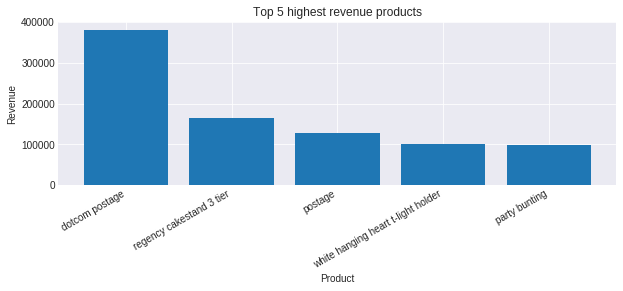

In [71]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(top_revenue.head()['description'],
       top_revenue.head()['revenue'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 highest revenue products")
plt.ylabel("Revenue");

Among the top 5 products in terms of revenue, we encounter again 3 familiar products: regency cakestand 3 tier, white hanging heart t-light holder and party bunting, which generate revenue between 98,000 to 165,000 dollars. These are also the most popular products, as we saw before. 

We can also see that two of the top 5 products in terms of revenue indicate payment for postage. It is probable that it did not go to the store, but customers paid a large amount of money on postage.

Let's remove postage related rows from the list so we can see more products.

In [72]:
## Drop products with 'postage' in their name

top_revenue_no_postage = top_revenue.drop(top_revenue[top_revenue['description'].str.contains('postage')].index)

## print top 5 without 'postage'

top_revenue_no_postage.head()

,description,revenue
2967,regency cakestand 3 tier,164762.19
4009,white hanging heart t-light holder,99668.47
2520,party bunting,98302.98
1901,jumbo bag red retrospot,92356.03
2852,rabbit night light,68127.75


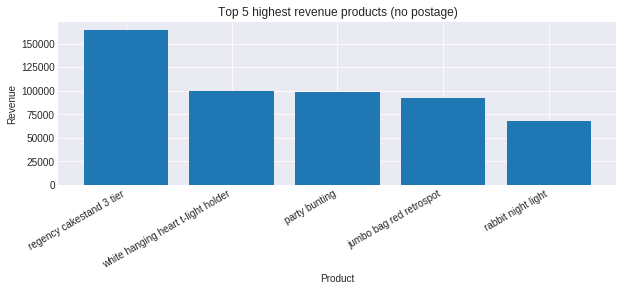

In [73]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(top_revenue_no_postage.head()['description'],
       top_revenue_no_postage.head()['revenue'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 highest revenue products (no postage)")
plt.ylabel("Revenue");

jumbo bag red retrospot, also one of the popular products, also brought a decent revenue. Another profitable product, that did not appear as one of the popular products is next - rabbit night light, but with a lower revenue sum. 

##### Conclusions

The 3 most popular products we saw earlier are also the ones that bring most revenue to the store. While 2 of the 3 bring almost 100,000 in revenue, 'regency cakestand 3 tier' is way ahead of them at the top with 165,000 dollars. We saw earlier that in terms of popularity, there's not much to separate these three. Perhaps a price adjustment could get the latter two closer. 

Another one is 'jumbo bag red retrospot', which also appeared in some of are popularity top 5s. The last one is 'rabbit night light', which made it to the top 5 in terms of revenue, despite not being one of the top 5 popular products. This suggests that the product is quite expensive, but still manages to bring a high revenue. Perhaps with the right promotion, this product could gain more popularity and bring even more revenues. 


We also saw that the largest amount of money is spent by the customers on postage. It is possible that if we find alternatives for our customers, we will be able to reduce their costs by a large share and be more attractive. This could be either by doing our own deliveries or offering more postage options.

#### Conclusions

In this section, we studied the most popular products in the dataset. We determined the most popular products using 3 rates: products with highest number of appearances in the dataset, products that occupy the largest share of total invoices, and products that were bought by the largest share of customers. There are 3 products that made it to the top 5 in all three rates: 'white hanging heart t-light holder', 'regency cakestand 3 tier' and 'party bunting'.

We then determined the products that bring most revenue to the store. The three most popular products ('white hanging heart t-light holder', 'regency cakestand 3 tier' and 'party bunting') are also among the top 5 in terms of revenue. We also suggested ways to increase revenues for other products.

Another issue we discovered is that the largest amount of money was spent by the customers on postage. This is probably not revenue that goes to the store. Therefore, we raised the suggestion that if we manage to cut postage expenses, our customers will be able to pay less and our products will be more attractive. 

### Seasonailty

One of the things that may affect the buying habits of the customers is seasonality. Sunscreens may get extremely popular during the summer, but much less demanded during the winter. In this chapter, we will investigate the following questions:
- How does seasonality affect the most popular products?
- What are the most popular products in each season?
- Is the average order size affected by seasonality? Are people buying more in a particular season?

#### Setting-up the Data

Our first step is to set up the data and divide our data to categories. For simplicity, we will only use two categories: Summer (April to September) and Winter (October to March).

We will first extract the month of each event. Then, we will use it to categorize.

In [74]:
## Get the month

df['month'] = df['invoicedate'].dt.month

In [75]:
## Create the function

def getSeason(row):
    if row >= 4 and row < 10:
        return "summer"
    else:
        return "winter"
    
## Categorize
        
df['season'] = df['month'].apply(getSeason)

#### Seasonality Effect on Popular Products

We would like to understand how different season affect the popularity of popular products. We will create a list of the most popular products we saw in the previous chapter. Then, we will count the number of appearances of each product during each season, and plot them side by side.

In [76]:
## Create a list of top products

popular_products = ['regency cakestand 3 tier', 'white hanging heart t-light holder', 'party bunting',
                   'jumbo bag red retrospot', 'lunch bag red retrospot']

## Group appearances by season and count

pop_prod = df.query('description in @popular_products').groupby('season')['description'].value_counts().to_frame()
pop_prod.columns = ['count']
pop_prod = pop_prod.reset_index()


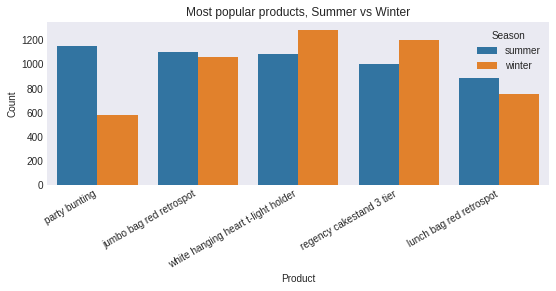

In [77]:
## Draw a bar plot

plt.figure(figsize=(9,3))

sns.barplot(data=pop_prod, x='description', y='count', hue='season')

plt.xticks(rotation=30, horizontalalignment="right");

plt.legend(title='Season');
plt.title('Most popular products, Summer vs Winter')
plt.xlabel('Product')
plt.ylabel('Count');

The chart shows how seasonality affects the popularity of the most popular products. We can see that most of them maintain, more or less, their popularity throught the year. 

However, party bunting is much less popular during the winter - perhaps people tend to have less parties during the winter. 

white hanging heart t-light holder is more popular during the winter, when lightning, and warm lightning in particular is more needed. regency cakestand 3 tier	is also more popular during the winter. 

Lunch bags are more popular during the summer, where people go out more and have lunch outside.

#### Popular Products in Each Season

Some products are probably more popular during a particular season, while others maintain their popularity throught the year. It would be interesting to see which products are most popular during each season.

We will use again our 3 rate for popularity:
1. Number of appearances in the dataset.
2. Share of invoices in which they appeared.
3. Share of customers by which they were bought.

##### Summer

**Appearances**

In [78]:
## Get a list of products with their number of appearances 

appearance_popularity_summer = df.query('season=="summer"')['description'].value_counts().to_frame().reset_index()
appearance_popularity_summer.columns = ['description', 'count']

## Print top 5

appearance_popularity_summer.sort_values(by='count', ascending=False).head()

,description,count
0,party bunting,1151
1,jumbo bag red retrospot,1100
2,white hanging heart t-light holder,1084
3,regency cakestand 3 tier,1004
4,spotty bunting,912


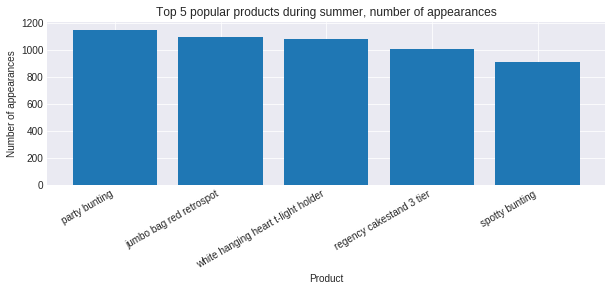

In [79]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(appearance_popularity_summer.sort_values(by='count', ascending=False).head()['description'],
       appearance_popularity_summer.sort_values(by='count', ascending=False).head()['count'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products during summer, number of appearances")
plt.ylabel("Number of appearances");

We're familiar with 4 products in the list, and introduce spotty bunting to the top 5. Similarly to the rising popularity of party bunting, people probably tend to have more parties during the summer, and the popularity of spotty bunting increased as well.

**Set-up the Data**

In [80]:
## For each product, count the number of unique invoices and customer Ids

unique_popularity_summer = df.query('season=="summer"').groupby('description').agg({'invoiceno': 'nunique', 'customerid': 'nunique'}).reset_index().sort_values(by='invoiceno', ascending=False)

## Calculate the share from total invoices\customer numbers

unique_popularity_summer['invoice_pct'] = unique_popularity_summer['invoiceno']/df.query('season=="summer"')['invoiceno'].nunique()*100
unique_popularity_summer['customerid_pct'] = unique_popularity_summer['customerid']/df.query('season=="summer"')['customerid'].nunique()*100

**Share of total invoices**

In [81]:
unique_popularity_summer[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()

,description,invoiceno,invoice_pct
2224,party bunting,1138,9.613110
1679,jumbo bag red retrospot,1088,9.190742
3478,white hanging heart t-light holder,1058,8.937320
2617,regency cakestand 3 tier,997,8.422031
3157,spotty bunting,897,7.577293


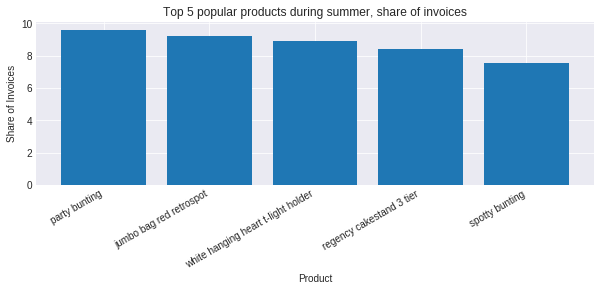

In [82]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_summer[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['description'],
       unique_popularity_summer[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['invoice_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products during summer, share of invoices")
plt.ylabel("Share of Invoices");

No change in our top 5, that appear in 7.5 to 9.6 percent of the invoices in the summer months.

**Share of total customers**

In [83]:
unique_popularity_summer[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()

,description,customerid,customerid_pct
2224,party bunting,549,18.484848
2617,regency cakestand 3 tier,547,18.417508
3478,white hanging heart t-light holder,525,17.676768
3157,spotty bunting,481,16.195286
1679,jumbo bag red retrospot,428,14.410774


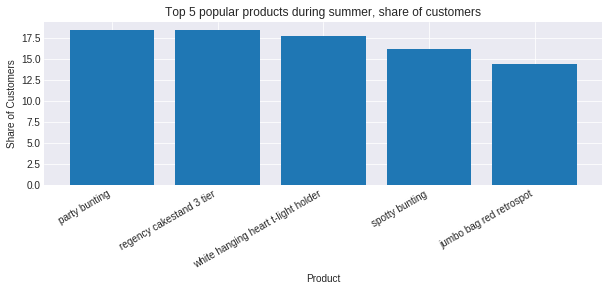

In [84]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_summer[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['description'],
       unique_popularity_summer[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['customerid_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products during summer, share of customers")
plt.ylabel("Share of Customers");

Still, no change in our top 5 products, but there are differences in the internal ranking. Spotty bunting was popular among wider audience than the jumbo bag. The most popular products were bought by 18.4% of our customers.

**Conclusions**

Party bunting, regency cakestand 3 tier, white hanging heart t-light holder, spotty bunting	and jumbo bag red retrospot	are with no doubt the most popular products by all rates. 

It seems that objects for parties gain extra popularity during the summer, with spotty bunting entering the top 5 list for the summer, and party bunting being the number one popular product for the summer. Perhaps the store should expand its variety of products for parties during this season.

##### Winter

We will follow the same process for the winter season.

**Appearances**

In [85]:
## Get a list of products with their number of appearances 

appearance_popularity_winter = df.query('season=="winter"')['description'].value_counts().to_frame().reset_index()
appearance_popularity_winter.columns = ['description', 'count']

## Print top 5

appearance_popularity_winter.sort_values(by='count', ascending=False).head()

,description,count
0,white hanging heart t-light holder,1285
1,regency cakestand 3 tier,1196
2,jumbo bag red retrospot,1059
3,set of 3 cake tins pantry design,954
4,paper chain kit 50's christmas,953


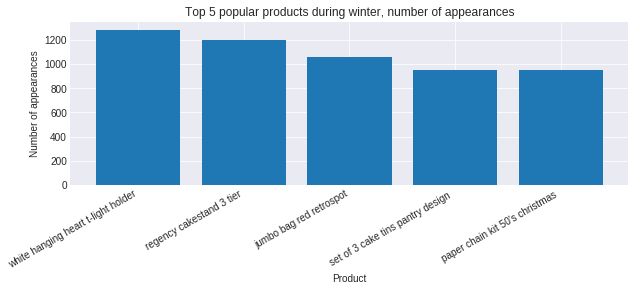

In [86]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(appearance_popularity_winter.sort_values(by='count', ascending=False).head()['description'],
       appearance_popularity_winter.sort_values(by='count', ascending=False).head()['count'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products during winter, number of appearances")
plt.ylabel("Number of appearances");

The first 3 products persist, but two new products enter the top 5 list: 'set of 3 cake tins pantry design' and 'paper chain kit 50's christmas'. 

It appears that the paper chain is the store's most popular christmas decoration product - this may be taken into account when preparing for the next holidays period. 

We also see that cake tins became more popular - we also saw that the regency cakestand gained more popularity during the winter. The demand for cake related products gets higher during the winter - this phenomena is probably related.

**Set-up the Data**

In [87]:
## For each product, count the number of unique invoices and customer Ids

unique_popularity_winter = df.query('season=="winter"').groupby('description').agg({'invoiceno': 'nunique', 'customerid': 'nunique'}).reset_index().sort_values(by='invoiceno', ascending=False)

## Calculate the share from total invoices\customer numbers

unique_popularity_winter['invoice_pct'] = unique_popularity_winter['invoiceno']/df.query('season=="winter"')['invoiceno'].nunique()*100
unique_popularity_winter['customerid_pct'] = unique_popularity_winter['customerid']/df.query('season=="winter"')['customerid'].nunique()*100

**Share of total invoices**

In [88]:
unique_popularity_winter[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()

,description,invoiceno,invoice_pct
3812,white hanging heart t-light holder,1244,8.846537
2808,regency cakestand 3 tier,1172,8.334519
1796,jumbo bag red retrospot,1047,7.445598
3089,set of 3 cake tins pantry design,943,6.706016
2351,paper chain kit 50's christmas,920,6.542455


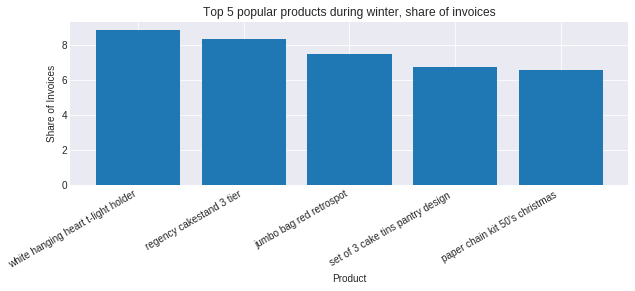

In [89]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_winter[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['description'],
       unique_popularity_winter[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['invoice_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products during winter, share of invoices")
plt.ylabel("Share of Invoices");

There's no change in the list of top 5 - the top products appear in 6.5 to 9% of the invoices.

**Share of total customers**

In [90]:
unique_popularity_winter[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()

,description,customerid,customerid_pct
3812,white hanging heart t-light holder,616,17.240414
2808,regency cakestand 3 tier,577,16.148894
2351,paper chain kit 50's christmas,500,13.993843
3089,set of 3 cake tins pantry design,497,13.909880
239,assorted colour bird ornament,463,12.958298


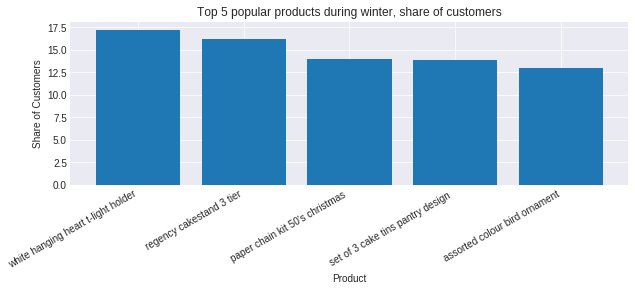

In [91]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_winter[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['description'],
       unique_popularity_winter[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['customerid_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products during winter, share of customers")
plt.ylabel("Share of Customers");

Once again we see that 'jumbo bag red retrospot' has a smaller audience, losing its place in the top 5 to bird ornament with 13% of the customers who bought it. No significant differences in the rest of the products, with 14-17% of the customers who bought them.

**Conclusions**

Three products remain popular during the winter as well: white hanging heart t-light holder, regency cakestand 3 tier and jumbo bag red retrospot. In addition to them, christmas decorations and set of 3 cake tins pantry design are also in the top 5. 

We see that cake products gain more popularity during the winter. Assorted colour bird ornament also gets in the top 5 on the expense of jumbo bag red retrospot, in terms of customer share who bought the product.

##### Conclusions

3 products maintain their popularity during both seasons:
1. white hanging heart t-light holder
2. regency cakestand 3 tier
3. jumbo bag red retrospot

Other than that, we can see that party decoration products are more popular during the summer, while during the winter, cake related products and christmas decorations are more popular.

#### Average Order Size

In this section, we will examine the average order size and how they vary during the different seasons. We will find the average revenue and average number of products per purchase.

We will sum the revenue per invoice and count the number of products for each season. Then, we will calculate the average revenue per invoice for each season.

In [92]:
## Sum revenue and count products per invoice, for each season

avg_order_size = df.groupby(['season', 'invoiceno']).agg({'revenue': 'sum', 'description': 'count'}).reset_index()

## Get the average of each season

avg_order_size.groupby('season').agg({'revenue': 'mean', 'description': 'mean'})

,revenue,description
season,,
summer,362.723250,19.345835
winter,403.438335,22.250960


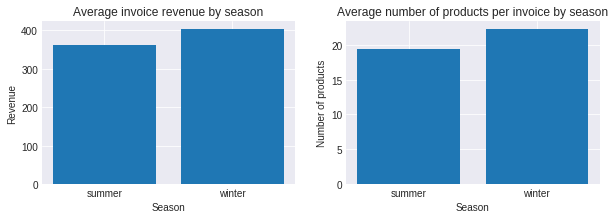

In [93]:
## Plot

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

ax[0].bar(avg_order_size.groupby('season').agg({'revenue': 'mean', 'description': 'mean'}).index,
       avg_order_size.groupby('season').agg({'revenue': 'mean', 'description': 'mean'})['revenue']);
ax[0].set_title('Average invoice revenue by season');
ax[0].set_xlabel('Season');
ax[0].set_ylabel('Revenue');
ax[0].grid();

ax[1].bar(avg_order_size.groupby('season').agg({'revenue': 'mean', 'description': 'mean'}).index,
       avg_order_size.groupby('season').agg({'revenue': 'mean', 'description': 'mean'})['description']);
ax[1].set_title('Average number of products per invoice by season');
ax[1].set_xlabel('Season');
ax[1].set_ylabel('Number of products');
ax[1].grid();

We can see that the average revenue and average number of products in each purchase is higher during the winter.

In winter, the revenue of the average purchase is 40$ higher than in summer. People also buy 3 more products, on average, during the winter.

#### Conclusions

In this section, we saw the effect of seasonality on the popularity of products and purchase habits of the customers.

We saw that some products are immune to seasonality, and are popular throught the year: white hanging heart t-light holder, regency cakestand 3 tier and jumbo bag red retrospot. 

However, other products are more popular during the winter (for example, party decorations). On winter, on the contrary, christmas decorations and cake related products are more popular. 

In addition to that, we saw differences between in the average revenue and order size in each season. The average purchase during the winter has a revenue higher by 40$ than in the winter, and an order size larger by 3 products. 

### Seniority

In this section, we will compare customers from two different groups: one-time customers against returning customers. We will address the following questions:
1. What is the average check of each group? Are one-time customers tend to seize the occasion, and buy more?
2. What are the most popular products in each group?

#### Setting-up the Data
First, we will categorize our data to the two groups. We will create a function that divides the customers based on the number of purchases. Less than 5 purchases is "onetimer", and more than that is "recurring". 

Then, we will calculate the number of purchases for each customer (the number of times they appear in the dataset, one time for each invoice number). We will get a list of users and their number of visits. We will merge this list to the original dataframe.

Then, we will apply the function using the new visits column.

In [94]:
## Create the function

def catCustomer(row):
    if row < 5:
        return "onetimer"
    else:
        return "recurring"
    
## Apply the function

#customer_visits = df.groupby('customerid')['customerid'].value_counts().to_frame()
customer_visits = df.groupby('customerid').agg({'invoiceno': 'nunique'})

In [95]:
## Re-arrange our customer visits table and rename columns

customer_visits = customer_visits.reset_index()
customer_visits.columns = ['customerid', 'visits']

In [96]:
## Merge customer visits table to the original table

df = df.merge(customer_visits, on='customerid', how='left')

## Create a new table, seniority, using our function and `visits` table

df['seniority'] = df['visits'].apply(catCustomer)

Now, let's erase the seniority value for rows where customer id is unknown.

In [97]:
df.loc[df.query('customerid=="unknown"').index] = df.loc[df.query('customerid=="unknown"').index].drop('seniority', axis=1)

In [98]:
## Check that it worked

df.query('customerid=="unknown"')['seniority'].unique()

array([nan], dtype=object)

Let's see how many customers there are in each group.

In [99]:
print("Number of recurring users: {}.".format(df.query('customerid!="unknown" and seniority=="recurring"')['customerid'].count()))
print("Number of one-time users: {}.".format(df.query('customerid!="unknown" and seniority=="onetimer"')['customerid'].count()))

Number of recurring users: 287166.
Number of one-time users: 119663.


We now have two groups of users, where recurring group is larger. However, we are comparing averages, and there are enough users in the one-time group for us to compare.

#### Average Order Size

In [100]:
seniority_avg_order_size = df.groupby(['seniority', 'invoiceno']).agg({'revenue': 'sum', 'description': 'count'}).reset_index()
seniority_avg_order_size.groupby('seniority').agg({'revenue': 'mean', 'description': 'mean'})

,revenue,description
seniority,,
onetimer,299.911234,20.196287
recurring,401.050830,17.655457


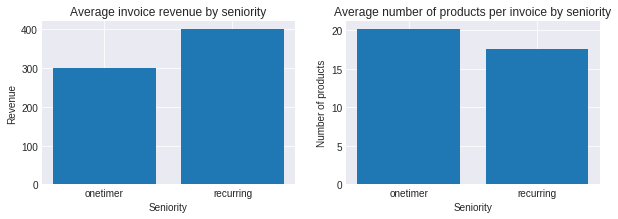

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

ax[0].bar(seniority_avg_order_size.groupby('seniority').agg({'revenue': 'mean', 'description': 'mean'}).index,
       seniority_avg_order_size.groupby('seniority').agg({'revenue': 'mean', 'description': 'mean'})['revenue']);
ax[0].set_title('Average invoice revenue by seniority');
ax[0].set_xlabel('Seniority');
ax[0].set_ylabel('Revenue');
ax[0].grid();

ax[1].bar(seniority_avg_order_size.groupby('seniority').agg({'revenue': 'mean', 'description': 'mean'}).index,
       seniority_avg_order_size.groupby('seniority').agg({'revenue': 'mean', 'description': 'mean'})['description']);
ax[1].set_title('Average number of products per invoice by seniority');
ax[1].set_xlabel('Seniority');
ax[1].set_ylabel('Number of products');
ax[1].grid();

The results are very clear. Recurring users are much more valuable customers for the store. Recurring users have an average order size higher by 100$ than onetimers. However, one-timer customers buy more products than recurring customers. Perhaps one-timers realize they will not be able to buy regularly, so they stuff-up the cart. This also mean that recurring customers buy more expensive products.

##### Popular Products by Seniority

We will use the same rates to check popularity of products by seniority.

##### One-timer users

**Appearances**

In [102]:
## Get a list of products with their number of appearances 

appearance_popularity_onetimer = df.query('seniority=="onetimer"')['description'].value_counts().to_frame().reset_index()
appearance_popularity_onetimer.columns = ['description', 'count']

## Print top 5

appearance_popularity_onetimer.sort_values(by='count', ascending=False).head()

,description,count
0,white hanging heart t-light holder,582
1,regency cakestand 3 tier,521
2,assorted colour bird ornament,455
3,rex cash+carry jumbo shopper,431
4,party bunting,382


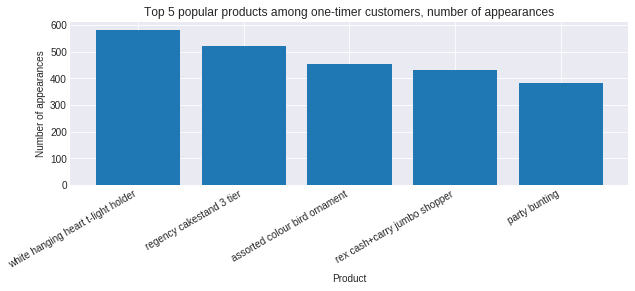

In [103]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(appearance_popularity_onetimer.sort_values(by='count', ascending=False).head()['description'],
       appearance_popularity_onetimer.sort_values(by='count', ascending=False).head()['count'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products among one-timer customers, number of appearances")
plt.ylabel("Number of appearances");

3 products are popular also among one timers - regency cakestand 3 tier, white hanging heart t-light holder and party bunting. We can also see that assorted colour bird ornament and carry jumbo shopper is popular among them.

**Share of total invoices**

In [104]:
## For each product, count the number of unique invoices and customer Ids

unique_popularity_onetimer = df.query('seniority=="onetimer"').groupby('description').agg({'invoiceno': 'nunique', 'customerid': 'nunique'}).reset_index().sort_values(by='invoiceno', ascending=False)

## Calculate the share from total invoices\customer numbers

unique_popularity_onetimer['invoice_pct'] = unique_popularity_onetimer['invoiceno']/df.query('seniority=="onetimer"')['invoiceno'].nunique()*100
unique_popularity_onetimer['customerid_pct'] = unique_popularity_onetimer['customerid']/df.query('seniority=="onetimer"')['customerid'].nunique()*100

In [105]:
unique_popularity_onetimer[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()

,description,invoiceno,invoice_pct
3452,white hanging heart t-light holder,557,9.400844
2565,regency cakestand 3 tier,516,8.708861
203,assorted colour bird ornament,433,7.308017
2612,rex cash+carry jumbo shopper,381,6.430380
2188,party bunting,373,6.295359


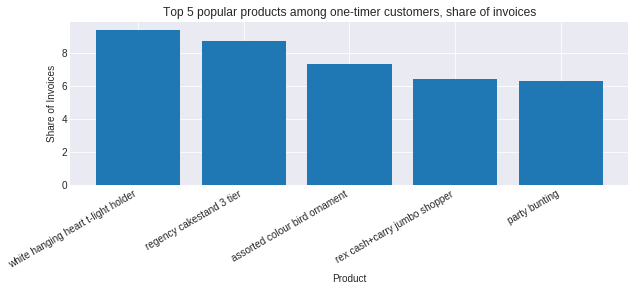

In [106]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_onetimer[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['description'],
       unique_popularity_onetimer[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['invoice_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products among one-timer customers, share of invoices")
plt.ylabel("Share of Invoices");

Top 5 popular products remain without a change, with 6-9% of the invoices.

**Share of total customers**

In [107]:
unique_popularity_onetimer[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()

,description,customerid,customerid_pct
2565,regency cakestand 3 tier,422,14.080747
3452,white hanging heart t-light holder,415,13.847181
203,assorted colour bird ornament,335,11.177845
2188,party bunting,312,10.410410
254,baking set 9 piece retrospot,306,10.210210


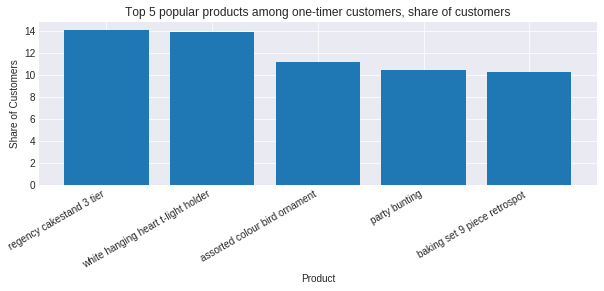

In [108]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_onetimer[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['description'],
       unique_popularity_onetimer[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['customerid_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products among one-timer customers, share of customers")
plt.ylabel("Share of Customers");

A small change where baking set gets in the top 5, the rest without a change, bought by 10-14% of the customers.

**Conclusions** 

regency cakestand 3 tier, white hanging heart t-light holder and party bunting are very popular also among one timer users, with shares of 6-8% of the invoices and 10.5 to 14% of the customers.

In [109]:
## Get a list of products with their number of appearances 

appearance_popularity_recurring = df.query('seniority=="recurring"')['description'].value_counts().to_frame().reset_index()
appearance_popularity_recurring.columns = ['description', 'count']

## Print top 5

appearance_popularity_recurring.sort_values(by='count', ascending=False).head()

,description,count
0,white hanging heart t-light holder,1488
1,regency cakestand 3 tier,1384
2,jumbo bag red retrospot,1333
3,lunch bag red retrospot,1138
4,party bunting,1034


##### Recurring users

**Appearance**

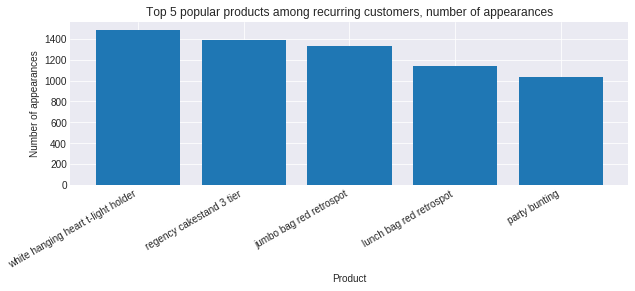

In [110]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(appearance_popularity_recurring.sort_values(by='count', ascending=False).head()['description'],
       appearance_popularity_recurring.sort_values(by='count', ascending=False).head()['count'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products among recurring customers, number of appearances")
plt.ylabel("Number of appearances");

Among the recurring users, the top 5 list contains the usual top 5 products.

**Share of total invoices**

In [111]:
## For each product, count the number of unique invoices and customer Ids

unique_popularity_recurring = df.query('seniority=="recurring"').groupby('description').agg({'invoiceno': 'nunique', 'customerid': 'nunique'}).reset_index().sort_values(by='invoiceno', ascending=False)

## Calculate the share from total invoices\customer numbers

unique_popularity_recurring['invoice_pct'] = unique_popularity_recurring['invoiceno']/df.query('seniority=="recurring"')['invoiceno'].nunique()*100
unique_popularity_recurring['customerid_pct'] = unique_popularity_recurring['customerid']/df.query('seniority=="recurring"')['customerid'].nunique()*100

In [112]:
unique_popularity_recurring[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()

,description,invoiceno,invoice_pct
3604,white hanging heart t-light holder,1456,8.951737
2686,regency cakestand 3 tier,1368,8.410698
1709,jumbo bag red retrospot,1319,8.109437
1884,lunch bag red retrospot,1111,6.830618
2273,party bunting,1026,6.308023


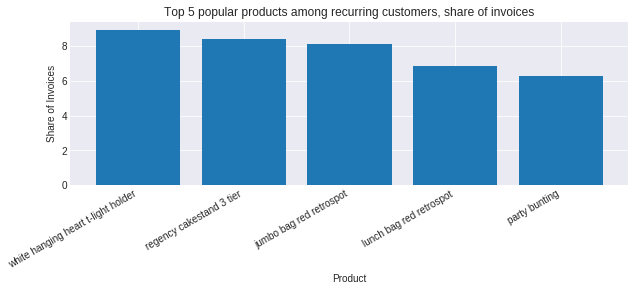

In [113]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_recurring[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['description'],
       unique_popularity_recurring[['description', 'invoiceno', 'invoice_pct']].sort_values(by='invoice_pct', ascending=False).head()['invoice_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products among recurring customers, share of invoices")
plt.ylabel("Share of Invoices");

No change in the popular products by share of total invoices. The most popular products appear in most invoices as well - 6.5 to 9% of them.

**Share of total customers**

In [114]:
unique_popularity_recurring[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()

,description,customerid,customerid_pct
2686,regency cakestand 3 tier,465,33.818182
3604,white hanging heart t-light holder,443,32.218182
2273,party bunting,396,28.800000
1709,jumbo bag red retrospot,390,28.363636
2199,pack of 72 retrospot cake cases,379,27.563636


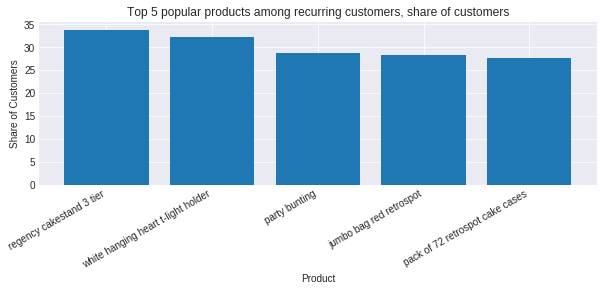

In [115]:
## Plot

plt.figure(figsize=(10,3))
plt.bar(unique_popularity_recurring[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['description'],
       unique_popularity_recurring[['description', 'customerid', 'customerid_pct']].sort_values(by='customerid_pct', ascending=False).head()['customerid_pct'])

plt.xticks(rotation=30, horizontalalignment="right");
plt.xlabel("Product")
plt.grid()
plt.title("Top 5 popular products among recurring customers, share of customers")
plt.ylabel("Share of Customers");

In the share of total customers, we can see some differences. 

First of all, we can see that the top 3 products in this list (regency cakestand 3 tier, white hanging heart t-light holder and party bunting) have much wider popularity among recurring customers than one timers. While these products were bought by 28-33% of the customers, they had popularity of up to 14% among one timer customers. This might suggest that these products could reach a wider audience by promoting them to new customers.

Second of all, we see once again that jumbo bag red retrospot and lunch bag red retrospot are less widely popular among the customers. Jumbo bag dropped a little and lunch bag lost its place in the top 5. Still, Jumbo bag was bought by 28.3% of the customers, not far from party bunting.

##### Conclusions

In this section, we compared the popularity of products between customer segments with different seniority level. We compared one-timer customers (actually, customers who purchased up to 5 times) and recurring customers, who purchased more than that. 

We saw that some products were popular in both groups. These are products that always come up as highly popular among different segments: **regency cakestand 3 tier, white hanging heart t-light holder and party bunting**. assorted colour bird ornament	was also popular in both groups, but not as the 3 above. Products in retrospot designs are popular among recurring customers, but by a relatively smaller share of them compared to other popular products. Among one-timer users, they are not as popular. Perhaps one timers are less exposed to these products.

In addition to that, we saw that the share of the popular products from the total number of customers who bought them, is lower for one timers. For one timers, the most popular products were bought by up to 14% of the customers, while for recurring they were bought by up to 33% of the customers. This might suggest that new users are not exposed enough to our top products. It is possible that with promotion to these products, we can reach higher shares and more sales of these products.

#### Conclusions

In this chapter, we divided our customers into two segments of their seniority, and analyzed the products they purchase. One group, the one-timers, are customers who purchased up to 5 different times in the store. The second group are recurring users - users who purchased more than 5 times.

After setting the two segments and assigning each transaction to a group, we analyzed the average order size of each group. We calculated the average revenue and the average number of products in each invoice in the two groups. We saw that recurring users buy, on average, much more than one timers. The revenue from recurring users is higher by 100$ than the revenue from one timers. However, while one timers buy 20 items on average, the average of recurring users is 17 items.

Then, we studied the difference in popular products in the two groups. We saw that 3 of the top 5 products are the same products that are popular across all other segments.  Also, we saw that the levels of popularity of the top products are much lower than among recurring customers. Perhaps we could promote our leading products among new users, and increase our sales.

### Analysis Conclusions

In the analysis chapter we intended to get better understanding of the most popular products in the dataset. We first studied the popularity of products in the entire dataset. Then, we saw how factors like seasonality and customer seniority affected this matter. 

We used three popularity tests for the products that checked number of appearances in absolute numbers, as a share out of all invoices, and popularity among customers. 

We were introduced to three products that were strong in all tests (white hanging heart t-light holder, regency cakestand 3 tier and party bunting), and others that were less widely popular (such as jumbo bag red retrospot and lunch bag red retrospot). We also saw clear differences when examining the effect of seasonality (party decorations are much more popular during summer) and by customer seniority (a smaller share of the one-timers buy the most popular products). 



## Hypotheses Tests

In the following section we will test two hypotheses that were raised during the analysis:
1. Seniority - That the average order value of recurring customers is higher than one-timers.
2. Seasonality - That the average order value during the winter is higher than during summer.

### Choosing the Right Test

Before we start, we should find the right test to use in these cases. We need to check if the populations are normal or not, and then decide the right method. We will use the will use the Shapiro–Wilk test for that. We will first set our 4 samples. Then, we will create a function for easier re-use. 

We are going to perform 6 tests: 4 normality tests, and two hypothesis tests. Therefore, we will set our significance level using the Bonferonni correction: `alpha = 0.05 / 6`

In [116]:
## Seniority test
onetimers_avg = df.query('seniority == "onetimer"').groupby('invoiceno').agg({'revenue': 'sum'})['revenue']
recurring_avg = df.query('seniority == "recurring"').groupby('invoiceno').agg({'revenue': 'sum'})['revenue']

## Seasonality test

winter_avg = df.query('season == "winter"').groupby('invoiceno').agg({'revenue': 'sum'})['revenue']
summer_avg = df.query('season == "summer"').groupby('invoiceno').agg({'revenue': 'sum'})['revenue']

Now, let's see explore the distribution of the samples. Let's print a quick histogram for all 4 samples.

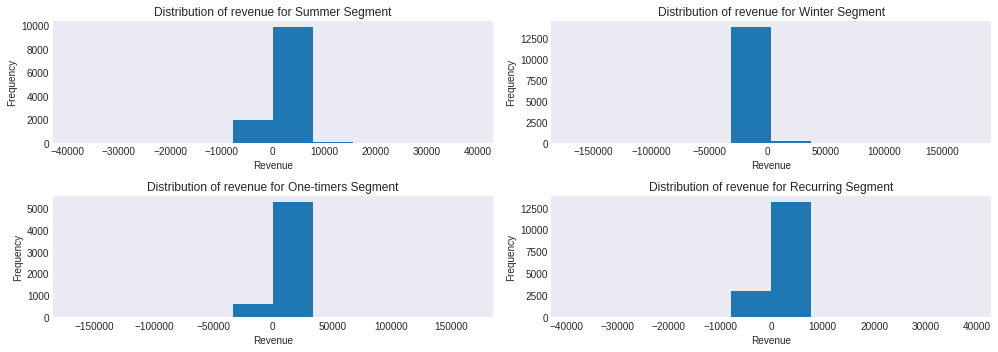

In [117]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,5))
ax[0,0].hist(summer_avg);
ax[0,1].hist(winter_avg);
ax[1,0].hist(onetimers_avg);
ax[1,1].hist(recurring_avg);

titles = [['Summer', 'Winter'], ['One-timers', 'Recurring']]
for i in range(0,2):
    for n in range(0,2):
        ax[i,n].set_xlabel('Revenue')
        ax[i,n].set_ylabel('Frequency');
        ax[i,n].set_title('Distribution of revenue for {} Segment'.format(titles[i][n]))
        
plt.tight_layout()

As we could see during the analysis, there are many outliers in the revenue column, and it does not look like a normal distribution. Let's run a shapiro-wilk test that will provide accurate determination on that matter.

In [118]:
## Setting significance level

alpha = .05 / 6

## Creating a function to run shapiro-wilk normality test

def shapiroWilk(sample):
    
    results = st.shapiro(sample)
    p_value = results[1] 

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Null hypothesis rejected: the distribution is not normal")
    else:
        print("Failed to reject the null hypothesis: the distribution seems to be normal") 

In [119]:
shapiroWilk(onetimers_avg)

p-value:  0.0
Null hypothesis rejected: the distribution is not normal


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [120]:
shapiroWilk(recurring_avg)

p-value:  0.0
Null hypothesis rejected: the distribution is not normal


In [121]:
shapiroWilk(winter_avg)

p-value:  0.0
Null hypothesis rejected: the distribution is not normal


In [122]:
shapiroWilk(summer_avg)

p-value:  0.0
Null hypothesis rejected: the distribution is not normal


As we expected, all 4 samples are not normally distributed. Therefore, we will have to use a non-parametric test to test our hypotheses. We will use the Wilcoxon-Mann-Whitney test. 

### Testing the Hypotheses

#### Setting-up the Test

Let's create a function that will run the test when given two samples.

In [123]:
## Creating a function that will run the Wilcoxon-Mann-Whitney test

def mannwhitneyu(sample1, sample2):
    results = st.mannwhitneyu(sample1, sample2)

    print('p-value: ', results.pvalue)

    if (results.pvalue < alpha):
        print("Null hypothesis rejected: the difference is statistically significant")
    else:
        print("Failed to reject the null hypothesis: we can't make conclusions about the difference") 


### Seniority

We will start with the seniority test, that will compare the average revenue per invoice of one-timer vs recurring customers.
Our null hypothesis is that the average revenue of the two groups is equal. The alternative hypothesis is that the average revenue between the two groups is different.

In [124]:
## Run the test

mannwhitneyu(onetimers_avg, recurring_avg)

p-value:  0.017164690406995538
Failed to reject the null hypothesis: we can't make conclusions about the difference


The test shows that there is no significant difference between the groups, and we cannot reject the null hypothesis that the average revenue of the two groups is equal. Therefore, despite an average higher by 100$, we cannot conclude that recurring users spend more than one-timers.

### Seasonality

We will now check the seasonality hypothesis. Our null hypothesis is that the average revenue in the two seasons is equal. The alternative hypothesis is that the average revenue in the two seasons is different.

In [125]:
## Run the test

mannwhitneyu(winter_avg, summer_avg)

p-value:  0.24475843481060888
Failed to reject the null hypothesis: we can't make conclusions about the difference


We failed to reject the null hypothesis. We cannot conclude that there is a difference in the average revenue in the two seasons. We saw earlier that the average revenue during the winter was higher, but the difference is not statistically significant. 

### Conclusions

In this chapter, we tested two hypothesis regarding the average revenue in two sets of segments of our data: one-time vs recurring customers, and winter vs summer transactions. 

During our analysis in the previous chapter, we saw that recurring customers had a greater average revenue than one-time customers. We also saw that the average revenue during the winter is greater than the average revenue during the summer. However, both hypotheses could not be proven by the statistical test. We cannot conclude that there is a difference between the groups.

## Conclusions and Recommendations

The goal of this project was to get better understanding of the product range in an online store that sells household goods. Using this project, it would be possible to optimize various areas in the operation of the store.

For our analysis, we used a dataset of the store's transactions for a period of around a year, from November 2018 to the end of 2019. After loading the data, we went through **preprocessing** of the data. We explored missing ,duplicated values and converted the columns to the correct datatype.

We then performed **exploratory data analysis**, to get to know the data a little bit better. We drew histograms and studied the distribution of the columns. We found anomalies and outliers in some columns and learned more about the others, and used this knowledge to articulate our analysis in the next chapter.

In the **analysis** section, we aimed to get better understanding of the most popular products in the store. We first investigated the popular products in the whole dataset, then after dividing the data to season and customer seniority.

during our analysis we discovered, for example, our top 3 products - white hanging heart t-light holder, regency cakestand 3 tier and party bunting. Perhaps the store could expand the variety of similar products, and provide a better service to our customers. 

We also saw the effect of seasonality and seniority on the popularity of products. For example, party decorations are much more popular during the summer. This insight should be used when ordering products to the store - it must prepare for higher demand during the summer, and maybe adjust the products it offers to customers. 

We could see that our most popular products are not widely popular among one-timers as they are among recurring customers. It is possible that if we promoted these products among one timers, it would lead to more sales of these porducts.

Finally, in the 5th chapter we **tested two hypotheses** that were raised during the analysis. We used non-parametric test to check the differences between the average revenue of invoices in two sets of segments: summer vs winter, and one-timer vs recurring customers. Both tests showed no significant difference between the groups. Therefore, despite the averages are being different in the analysis, we cannot conclude that either group has a higher average revenue. 

This means that there is no evidence that the average revenue during the winter is higher than in summer, and we cannot conclude that recurring customers pay more on average than one timers. We can use this infomation to know that we can divide marketing efforts equally between these two segments. 